We investigate the tax burden and insurance cost for different scenarios of gross income using a simplified model of the situation in Germany. The goal is to compute the marginal net income for additional gross income. From that, we can also derive the net hourly income for part-time employment.

This analysis is done using [Julia](https://julialang.org/) in a [Jupyter](https://jupyter.org/) notebook.

In [1]:
# assume a typical monthly income
gross_monthly = 37873 / 12

3156.0833333333335

## Social costs

For simplicity, we ignore the possibility of private health insurance and assume that our typical employee participates in the public social system. This includes health insurance, _unemployment insurance_ and payments to the pension system.

These payments are split evenly between the employer and employee. This means that the labor cost of the employer is higher than the gross salary paid.

Source: [nettolohn.de](https://www.nettolohn.de)

In [2]:
# only includes the employee's share
pension = 0.186
unemployment = 0.03
health = 0.146
longterm_care = 0.028
base_rate = 0.5 * (pension + unemployment + health + longterm_care)
health_extra = 0.011
employer_rate = base_rate
employee_rate = base_rate + health_extra
@show employer_rate, employee_rate;

(employer_rate, employee_rate) = (0.195, 0.20600000000000002)


In [3]:
# effective labor cost for employer
real_monthly = (1.0 + employer_rate) * gross_monthly

3771.5195833333337

However, these relative rates are only applied up to specific bound for the gross income.
So, let's define some functions to compute the correct costs.

In the case of self-employment, there is also a _virtual minimum income_ that is used as a reference, which we will ignore for simplicity.

Source: [Beitragsbemessungsgrenze](https://de.wikipedia.org/wiki/Beitragsbemessungsgrenze)

In [4]:
function social_cost(gross_monthly)
    pension       = 0.186 * min(gross_monthly, 6500.0)
    unemployment  = 0.030 * min(gross_monthly, 6500.0)
    health        = 0.146 * min(gross_monthly, 4425.0)
    longterm_care = 0.146 * min(gross_monthly, 4425.0)
    pension + unemployment + health + longterm_care
end

employer_cost(gross_monthly) = 0.5 * social_cost(gross_monthly)
employee_cost(gross_monthly) = 0.5 * social_cost(gross_monthly) + 0.011 * gross_monthly
total_cost(gross_monthly) = employer_cost(gross_monthly) + employee_cost(gross_monthly)
employer_total(gross_monthly) = employer_cost(gross_monthly) + gross_monthly;

Let's visualize the total social cost relative to the real monthly labor cost.

In [5]:
using Plots
gr()

Plots.GRBackend()

In [6]:
gross_range = 400.0:20.0:10000.0
real_income = employer_total.(gross_range)
relative_cost = total_cost.(gross_range) ./ real_income
plot(real_income, relative_cost, xlim=(0,11000), ylim=(0.0, 0.5), legend=false,
     xlabel="effective monthly income", ylabel="rel social cost")

So, higher gross (or effective) income leads to a smaller relative social cost.
We can repeat that plot for the employee's point of view:

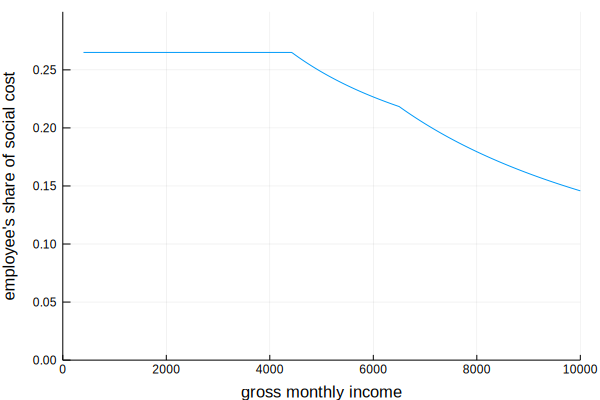

In [7]:
plot(gross_range, employee_cost.(gross_range)./gross_range, xlim=(0,10000), ylim=(0.0, 0.3), legend=false,
     xlabel="gross monthly income", ylabel="employee's share of social cost")

The income tax only applies to the part of the gross income of which the social cost has been subtracted already.
Further, some portion of that remainder is also free from taxes.

In [8]:
taxable_income(gross_monthly) = gross_monthly - employee_cost(gross_monthly)

taxable_income (generic function with 1 method)

## Income tax

The tax rate is a piece-wise defined function.
We assume an unmarried employee with no kids who is not taxable by any church.

The source below actually contains flow charts with details conditions, thresholds and rounding of intermediate results.
I can't be bothered to understand all of that, so I will try to extract the essential information.

Source: [BMF Steuerrechner](https://www.bmf-steuerrechner.de/bl2018/)

In [9]:
function income_tax(yearly)
    if yearly <= 9000
        return 0
    elseif yearly < 13997
        y = (yearly - 9000) / 10000
        rw = y * 997.8 + 1400
        return ceil(rw * y)
    elseif yearly < 54950
        y = (yearly - 13996) / 10000
        rw = y * 220.13 + 2397
        return ceil(rw * y + 948.49)
    elseif yearly < 260533
        return ceil(yearly * 0.42 - 8621.75)
    else
        return ceil(yearly * 0.45 - 16437.7)
    end
end

income_tax (generic function with 1 method)

In [10]:
yearly_range = 5000:500:100000
plot(yearly_range, income_tax.(yearly_range), legend=false, xlim=(0,100000), ylim=(0,35000),
    xlabel="yearly taxable income", ylabel="income tax")

In [11]:
plot(yearly_range, income_tax.(yearly_range) ./ yearly_range, legend=false, xlim=(0,100000), ylim=(0,0.4),
    xlabel="yearly taxable income", ylabel="income tax rate")

## Net income

Now, let's combine the social costs and taxes to compute the net income.

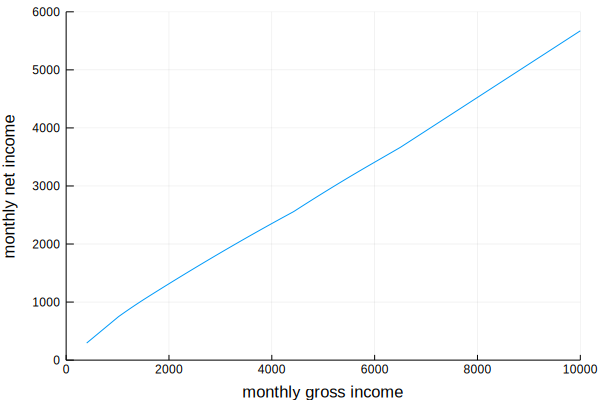

In [12]:
function net(gross_monthly)
    taxable = taxable_income(gross_monthly)
    taxes = income_tax(ceil(12 * taxable)) / 12
    taxable - taxes
end

net_income = net.(gross_range)

plot(gross_range, net_income, legend=false, xlim=(0,10000), ylim=(0,6000),
     xlabel="monthly gross income", ylabel="monthly net income")

This looks surprisingly linear. Let's also plot the relative net income compared to the effective cost.

In [13]:
rel_net = net_income ./ real_income
plot(real_income, rel_net, legend=false, xlim=(0,12000), ylim=(0,0.7),
     xlabel="effective monthly income", ylabel="rel net income")

Interestingly, this curve is not monotonically decreasing. In fact, there seems to be a minimum at a gross income of 4425 (real income of about 5300), which is the upper reference value for the health insurances.

## Marginal income

The analysis above can be slightly misleading. If we are currently earning a certain income and have an opportunity to raise the income, this might also decrease our relative net income. However, higher rates for social cost and income tax are applied equally to the _previous_ and _additional_ income.

If we want to show how much net income we can retain for each additional EUR earned, we have take some more care.
Here, we approximate the slope of the net income as a function of real income using a symmetric difference quotient.
There are some jumps in that curve since our net income is not smooth.

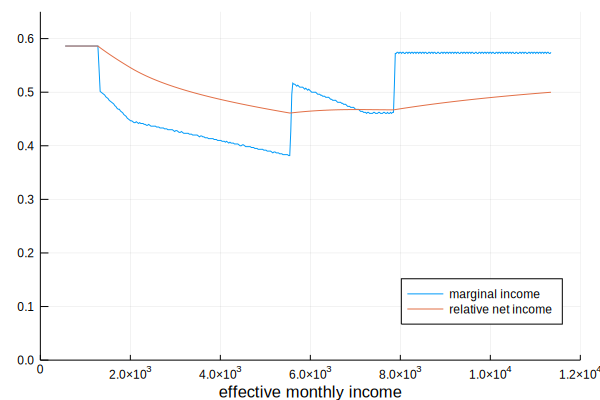

In [14]:
finite_diffs = (net_income[3:end] - net_income[1:end-2]) ./ (real_income[3:end] - real_income[1:end-2])
plot(real_income[3:end], [finite_diffs rel_net[3:end]], xlim=(0,12000), ylim=(0,0.65),
    xlabel="effective monthly income", label=["marginal income" "relative net income"],
    legend=:bottomright)

## Part-time work and hourly income

We have seen that a lower gross income often corresponds to a higher relative net income.
If we have the option to reduce our working hours, we should be able to increase our income per hour.

Let's assume a 40 hour work-week and 4 weeks per month.

In [15]:
monthly_hours = 40.0 * 4.0

160.0

In [16]:
# median income
median_net = net(gross_monthly)

1929.0545833333333

In [17]:
median_net / monthly_hours

12.056591145833334

In [18]:
using ColorBrewer

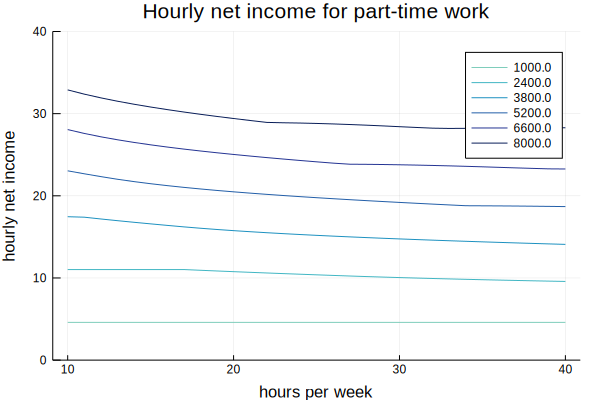

In [19]:
# hourly income for different monthly gross incomes
hours = 10:40
steps = 6
gross = range(1000, stop=8000, length=steps)'
colors = ColorBrewer.palette("YlGnBu", steps + 3)[4:end]
parttime_net = net.((hours / 40)*gross)
hourly_net = parttime_net ./ (hours * 4)
plot(hours, hourly_net, labels=gross, ylim=(0,40),
     color_palette=colors,
     xlabel="hours per week", ylabel="hourly net income",
     title="Hourly net income for part-time work")

As we can see above, we can increase our hourly income by working fewer hours every week.
This effect is more clear if we look at the hourly net income of part-time work relative the hourly net income for full-time work:

In [20]:
rel_hourly = hourly_net ./ hourly_net[end, :]';

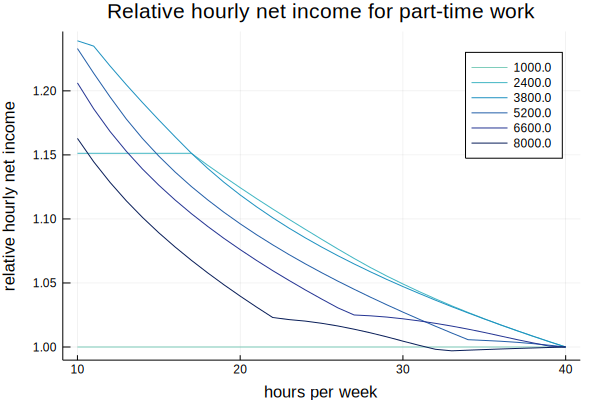

In [21]:
plot(hours, rel_hourly, labels=gross, color_palette=colors,
     xlabel="hours per week", ylabel="relative hourly net income",
     title="Relative hourly net income for part-time work")

For low values of gross income, reducing the weekly work hours will not affect the hourly income any more.
Medium values show the most promise, with the largest inrease in hourly income.
With a high enough income, reducing the work load yields less and less increase in hourly income.